# Titanic Data Wrangler
We will process the data based on some observations in the EDA.
* Add Section column based on Cabin first character
* Use clustering to add a feature
* Drop unneeded columns Name, Ticket, Cabin
* Bin the ages into groups
* Apply one-hot encoding to PClass, Parch, SibSp, Embarked, Sex, and Age Group




In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pprint
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
try:
    for dirname, _, filenames in os.walk('../kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
except:
    for dirname, _, filenames in os.walk('../kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../kaggle/input/titanic/gender_submission.csv
../kaggle/input/titanic/test.csv
../kaggle/input/titanic/train.csv


In [2]:
train_data = pd.read_csv("../kaggle/input/titanic/train.csv")
test_data = pd.read_csv("../kaggle/input/titanic/test.csv")
train_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Add a cluster feature.

In [4]:
km = KMeans(n_clusters=24)
km.fit(train_data[["SibSp","Parch", "Pclass"]])
train_data["cluster"] = km.labels_
km.fit(test_data[["SibSp","Parch", "Pclass"]])
test_data["cluster"] = km.labels_


### Deal with NaNs

In [5]:
# Replace NaN's in other columns with something
train_data["Cabin"].fillna("X", inplace=True) # X for no klnown cabin
train_data["Embarked"].fillna("U", inplace=True) # U for unknown embarkation
train_data["Age"].fillna(-1, inplace=True) # U for unknown age
train_data["Fare"].fillna(0, inplace=True)
# do the same for the test file data
test_data["Cabin"].fillna("X", inplace=True) # X for no klnown cabin
test_data["Embarked"].fillna("U", inplace=True) # U for unknown embarkation
test_data["Age"].fillna(-1, inplace=True) # U for unknown age
test_data["Fare"].fillna(0, inplace=True)

### Add a section column
Extract what appears to be a section ID from the cabin feature and add it as a column

In [6]:
train_data["Section"] = train_data["Cabin"].str.slice(0,1)
test_data["Section"] = train_data["Cabin"].str.slice(0,1)

### Bin the ages based on the EDA

In [7]:
train_data["AgeBin"] = pd.cut(train_data["Age"], [-10,0,10,20,45,120], labels=["Unknown", "Child", "Youth", "Adult", "Old"])
test_data["AgeBin"] = pd.cut(test_data["Age"], [-10,0,10,20,45,120], labels=["Unknown", "Child", "Youth", "Adult", "Old"])

In [8]:
train_data_onehot = pd.get_dummies(train_data, columns=["AgeBin", "Sex", "Embarked", "Section", "Pclass", "Parch", "SibSp"])
train_data_onehot.drop(columns = ["Name", "Ticket", "Cabin"], inplace=True) # These columns don't seem to add anything to predictions
train_data_onehot.head()

,PassengerId,Survived,Age,Fare,cluster,AgeBin_Unknown,AgeBin_Child,AgeBin_Youth,AgeBin_Adult,AgeBin_Old,...,Parch_4,Parch_5,Parch_6,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8
0,1,0,22.0,7.2500,10,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,2,1,38.0,71.2833,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,3,1,26.0,7.9250,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,4,1,35.0,53.1000,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,5,0,35.0,8.0500,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [9]:
# Do the same for the test data
test_data_onehot = pd.get_dummies(test_data, columns=["AgeBin","Sex", "Embarked", "Section", "Pclass", "Parch", "SibSp"])
test_data_onehot.drop(columns = ["Name", "Ticket", "Cabin"], inplace=True) # These columns don't seem to add anything to predictions
test_data_onehot.head()

,PassengerId,Age,Fare,cluster,AgeBin_Unknown,AgeBin_Child,AgeBin_Youth,AgeBin_Adult,AgeBin_Old,Sex_female,...,Parch_5,Parch_6,Parch_9,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8
0,892,34.5,7.8292,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1,893,47.0,7.0000,14,0,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0
2,894,62.0,9.6875,6,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,895,27.0,8.6625,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,896,22.0,12.2875,13,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0


After one-hot encoding, there exists a column mismatch between the two data sets. This will casue problems further down the road so we add the missing columns to each data set and then sort the columns so each one will match with the exception of the "Survived" column.

In [10]:
# Values that were not in both data sets 
# Add missing columns to each set so scaling will work later
train_data_onehot["Parch_9"] = np.zeros(train_data.shape[0], dtype=np.uint8)
test_data_onehot["Embarked_U"] = np.zeros(test_data.shape[0], dtype=np.uint8)
train_columns = train_data_onehot.columns.drop("Survived").tolist()
test_columns = test_data_onehot.columns.tolist()
train_columns.sort()
test_columns.sort()
train_columns.append("Survived")
train_data_onehot = train_data_onehot[train_columns]
test_data_onehot = test_data_onehot[test_columns]
print(train_data_onehot.columns)
print(test_data_onehot.columns)

Index(['Age', 'AgeBin_Adult', 'AgeBin_Child', 'AgeBin_Old', 'AgeBin_Unknown',
       'AgeBin_Youth', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Embarked_U',
       'Fare', 'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4',
       'Parch_5', 'Parch_6', 'Parch_9', 'PassengerId', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Section_A', 'Section_B', 'Section_C', 'Section_D',
       'Section_E', 'Section_F', 'Section_G', 'Section_T', 'Section_X',
       'Sex_female', 'Sex_male', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3',
       'SibSp_4', 'SibSp_5', 'SibSp_8', 'cluster', 'Survived'],
      dtype='object')
Index(['Age', 'AgeBin_Adult', 'AgeBin_Child', 'AgeBin_Old', 'AgeBin_Unknown',
       'AgeBin_Youth', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Embarked_U',
       'Fare', 'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4',
       'Parch_5', 'Parch_6', 'Parch_9', 'PassengerId', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Section_A', 'Section_B', 'Section_C', 'Section_D',
       'Sec

<AxesSubplot:title={'center':'Correlation Matrix with Binned Ages'}>

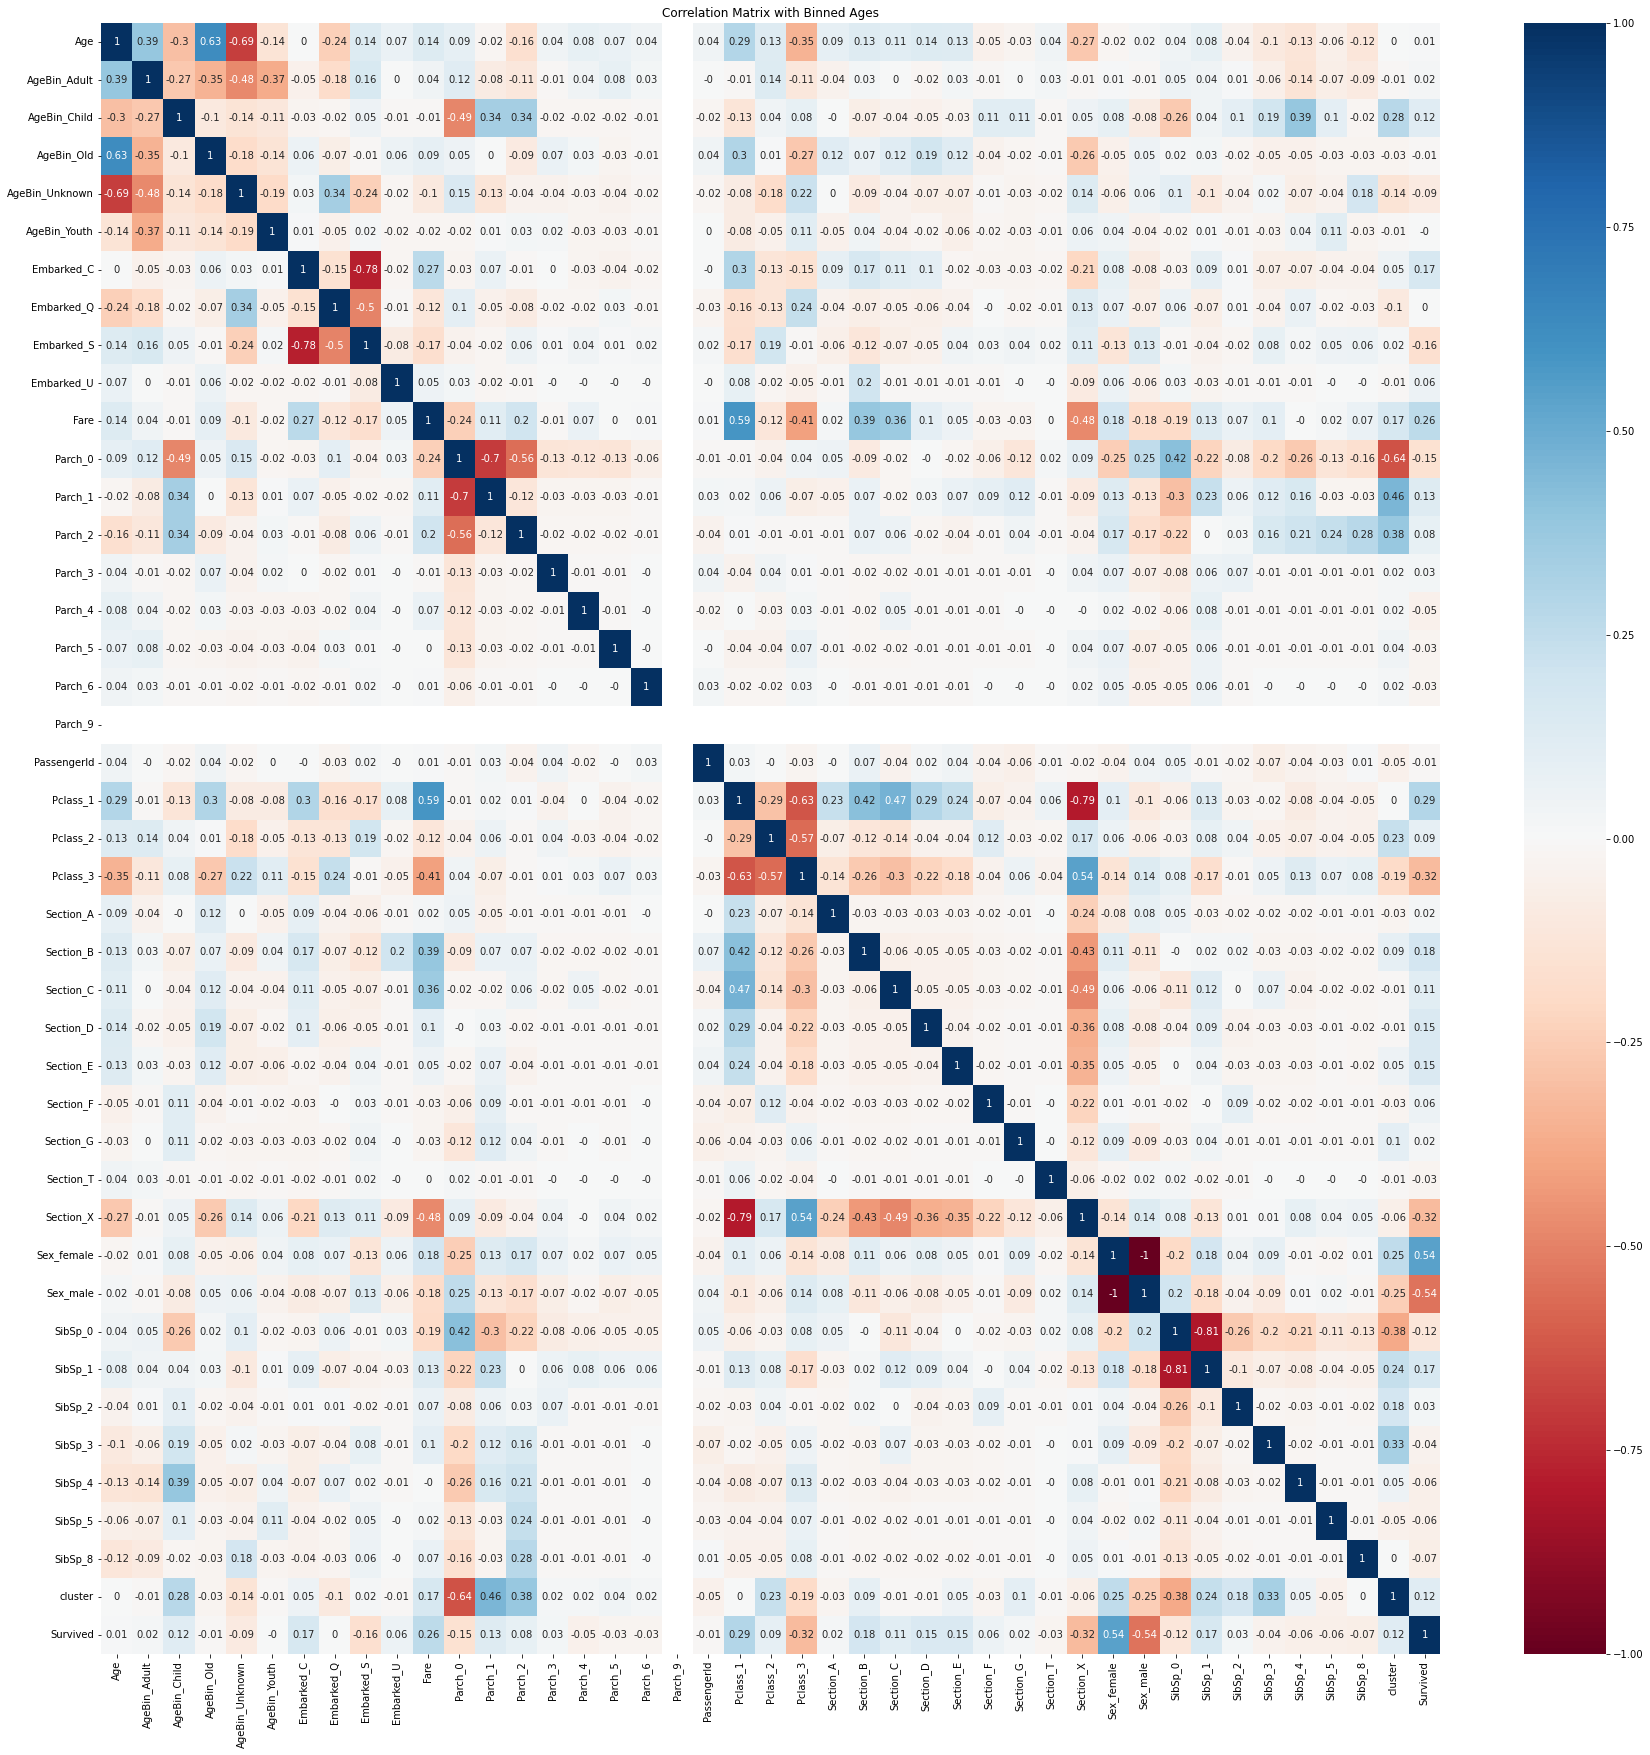

In [11]:
# plot a correlation matrix to get a clue
corr_m = train_data_onehot.corr(numeric_only=True).round(2)
fig, ax = plt.subplots(figsize=(30,30))
plt.title("Correlation Matrix with Binned Ages")
sns.heatmap(corr_m, annot=True, cmap='RdBu')

In [12]:
train_data_onehot.head()

,Age,AgeBin_Adult,AgeBin_Child,AgeBin_Old,AgeBin_Unknown,AgeBin_Youth,Embarked_C,Embarked_Q,Embarked_S,Embarked_U,...,Sex_male,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,cluster,Survived
0,22.0,1,0,0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,0,10,0
1,38.0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,26.0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,1
3,35.0,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
4,35.0,1,0,0,0,0,0,0,1,0,...,1,1,0,0,0,0,0,0,1,0


In [13]:
test_data_onehot.head()

,Age,AgeBin_Adult,AgeBin_Child,AgeBin_Old,AgeBin_Unknown,AgeBin_Youth,Embarked_C,Embarked_Q,Embarked_S,Embarked_U,...,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,cluster
0,34.5,1,0,0,0,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
1,47.0,0,0,1,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,14
2,62.0,0,0,1,0,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,6
3,27.0,1,0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,0,0
4,22.0,1,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,13


### Saving files
* (train|test)_data_binned_onehot.csv : data set with NaNs replaced and assigned to a cluster based on SibSp, Parch, and Pclass, and binned by age, all one-hot encoded



In [14]:
train_data_onehot.to_csv("../kaggle/working/train_data_binned_onehot.csv")
test_data_onehot.to_csv("../kaggle/working/test_data_binned_onehot.csv")